# Convergence

In [109]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from ema_workbench import (MultiprocessingEvaluator, ema_logging, RealParameter, ScalarOutcome, Constant,
                           Model, HypervolumeMetric, save_results)
from ema_workbench.em_framework.optimization import (GenerationalBorg, epsilon_nondominated, to_problem, ArchiveLogger,
                                                     EpsilonProgress)

if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

### BASE CASE

In [110]:
# Model definition

from model_zambezi_OPT import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    # print('len kwargs is', len(kwargs)) = 230
    Hydropower, Environment, Irrigation = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE)]


#Problem definition
problem = to_problem(model, searchover="levers")


In [111]:
#Run definition

nfe = 200000 #
seeds = 5
run_comment = 'BC'
run_label = f"{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()


'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\BC_200000nfe_5seed'

In [112]:
#Change the load archives method of the ArchiveLogger class

import tarfile
import os
import pandas as pd

def alternative_load_archives(filename):
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), index_col=0)
                if not df.empty:
                    archives[int(key)] = df
    #print(archives)
    return archives

ArchiveLogger.load_archives = alternative_load_archives


In [113]:
#Merge convergences 

convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 
    #print(f'convergence{i}')

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)


column_names = ['Hydropower', 'Environment', 'Irrigation']

results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv") # Create the results list, containing dataframes with the results per seed 
    globals()[f'df_{i}'] = pd.read_csv(f"results_seed{i}.csv", usecols = column_names) # create dataframes per seed with results for analysis
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)



In [6]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.4] * len(model.outcomes), problem)  # [0.05]
len(reference_set)
#print('reference_set type is', type(reference_set))

126

In [7]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

from datetime import datetime

before = datetime.now()
print("time before is", before)

time before is 2024-02-26 11:38:18.741572


In [14]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True)
    metrics_name = 'metrics.csv'
    #metrics.to_csv(os.path.join(cwd, metrics_name))

    metrics_by_seed.append(metrics)


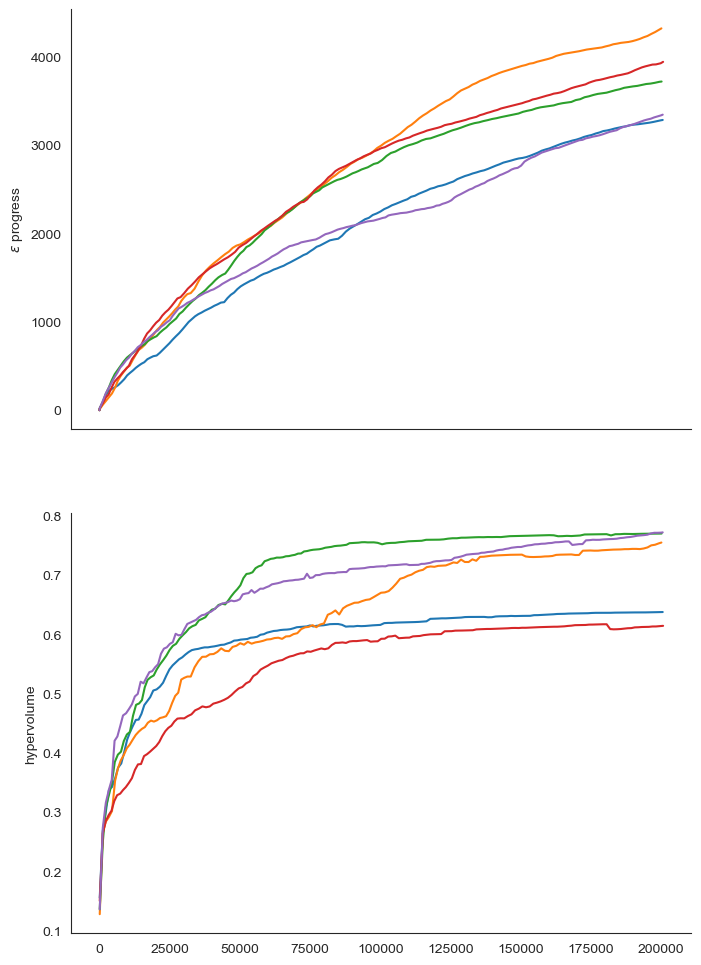

It took 0:06:04.575362 time to do 99705 nfes


In [15]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes
import matplotlib.pyplot as plt

for metrics, convergence in zip(metrics_by_seed, convergences):
    #plt.rcParams["font.family"] = "sans-serif"
    ax1.plot(convergence.nfe, convergence.epsilon_progress)
    ax1.set_ylabel("$\epsilon$ progress")    
    
    ax2.plot(metrics.nfe, metrics.hypervolume)
    ax2.set_ylabel("hypervolume")
    
sns.despine(fig)


plt.show()

after = datetime.now()
print(f"It took {after - before} time to do {nfe} nfes")

In [11]:
#Hypervolume hvwfg

import sys
sys.path
path = r'C:\users\whitl\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages'
sys.path.append(path)
sys.path

import hvwfg

array_df0 = df_0.values.copy()
array_df0

array_ref_set = ref_set.values.copy()

arr_df0 = df_0.values.to_numpy().copy()
arr_df0


seed_keys = []
result_values = []
for key, value in archives.items():
    seed_keys.append(key)
    for i in range(len(seed_keys)):
        #print("Key:", key)#, "Value:", value)

hvwfg.wfg(arr_df0, array_ref_set)

In [12]:
# Fitness vector assuming minimization
obj = np.array([[0.3, 0.6],
                [0.4, 0.4],
                [0.6, 0.2]])

ref = np.array([1.1, 1.1])

hvwfg.wfg(obj, ref)


0.6400000000000001

In [123]:
# Get the worst values (Nadir point)

# Load the merged results
column_names = ['Hydropower', 'Environment', 'Irrigation']
df_bc = pd.read_csv(f"merged_results.csv", usecols = column_names)#, index_col=0) #, usecols = column_names)

worst_hyd = df_bc.Hydropower.max()
worst_irr = df_bc.Irrigation.max()
worst_env = df_bc.Environment.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_bc.Hydropower.min()
best_irr = df_bc.Irrigation.min()
best_env = df_bc.Environment.min()

best_list = []
best_list.append(best_hyd)
best_list.append(best_env)
best_list.append(best_irr)

In [115]:
print(worst_list)

[20.17937625072075, 3214070.319504687, 3.074369590148062]


In [134]:
import tarfile
import os
import pandas as pd

column_names = ['Hydropower', 'Environment', 'Irrigation']

def alternative_load_archives(filename):
    archives = {}
    normalized_archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                normalized_df=(df-df.min())/(df.max()-df.min())
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                if not df.empty:
                    archives[int(key)] = df
                if not normalized_df.empty:
                    normalized_archives[int(key)] = normalized_df
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, normalized_archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives


In [135]:
#zeros = [0.0,0.0,0.0]
worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
    #[0.0,0.0,0.0])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0])
    #30.17937625072075, 4214070.319504687, 4.074369590148062])
#worst_array = np.asarray(zeros)

In [136]:
#NORMALIZATION?
#normalized_archives

In [137]:
# Load the archives
#all_archives = []
#all_hvs = {}
all_norm_hvs = []
norm_hvs_dict = {}
norm_hvs_dict_0 = {}
norm_hvs_dict_1 = {}
norm_hvs_dict_2 = {}
norm_hvs_dict_3 = {}
norm_hvs_dict_4 = {}
norm_hvs_dict_5 = {}

hvs_dict_0 = {}
hvs_dict_1 = {}
hvs_dict_2 = {}
hvs_dict_3 = {}
hvs_dict_4 = {}
hvs_dict_5 = {}

for i in range(seeds):
    norm_hvs_this_seed = []
    archives, normalized_archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    #print(archives)
    #all_archives.append(archives)
    '''
    sorted_archives = dict(sorted(archives.items()))
    for key, value in sorted_archives.items():
        #print(type(value))
        #normalized_value=(value-value.min())/(value.max()-value.min())
        o = value.values
        norm_o = normalized_value.values
        #print(type(o))
        #print(value)
        objs = np.ascontiguousarray(o)
        norm_objs = np.ascontiguousarray(norm_o)
        if key < 100:
            print('objs::',o)
            print('norm objs::',norm_o)
            print('worst array::', worst_array)
        #print(objs.shape)
        #array_reference_set = reference_set.values.copy()
        hv = hvwfg.wfg(objs, 
                       worst_array)
        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)
        if key < 110:
            print('hv::',hv)
            print('norm_hv::',norm_hv)
        all_hvs.append(hv)
        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv
            hvs_dict_0[int(key)] = hv
        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv
            hvs_dict_1[int(key)] = hv
        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv
            hvs_dict_2[int(key)] = hv
        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv
            hvs_dict_3[int(key)] = hv
        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv
            hvs_dict_4[int(key)] = hv
        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv
            hvs_dict_5[int(key)] = hv
'''
    norm_sorted_archives = dict(sorted(norm_archives.items()))
    for key, value in norm_sorted_archives.items():

        o = value.values

        norm_objs = np.ascontiguousarray(o)
        if key < 100:
            print('objs:', norm_objs)
            
        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)
        if key < 110:
            print('norm_hv::',norm_hv)

        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv

        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv

        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv

        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv

        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv

        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv

    
    print('all hvs for seed', i, ':', norm_hvs_this_seed)
            #print("Key:", hv)#, "Value:", value)
norm_hvs_dict_0
    #all_hvs
#all_norm_hvs
    #for i in range(len(all_archives)):
#    print(i)
#print(all_archives)

norm_hv:: 0.07330550912985925
all hvs for seed 0 : [0.07330550912985925, 0.15488095747651823, 0.18134989834509632, 0.21936289577037313, 0.2231257281040233, 0.2417819324271439, 0.261452320969628, 0.2683027034169202, 0.28894281297230034, 0.3168967193852996, 0.33335055149986886, 0.34697048080541215, 0.3608336267449714, 0.3614604946197512, 0.3742494265377256, 0.39322747160532096, 0.40277416323697063, 0.41119238806197217, 0.42577700438750066, 0.4284727810315721, 0.4354640523115161, 0.4436081094349855, 0.45796021184913427, 0.4723261771673456, 0.4802654160088053, 0.48682486507492295, 0.49308055339071694, 0.49727326932914606, 0.5023724843884422, 0.5073684862314908, 0.5116937566655565, 0.5135056863041487, 0.5147409426184029, 0.5159193865625833, 0.5172602478092634, 0.5175394474148176, 0.5185374622644533, 0.5195162119905261, 0.5210110805928588, 0.5229446731783539, 0.523287625045012, 0.5254053179402502, 0.5272485166207082, 0.5314358030519443, 0.5308973102506557, 0.5326968250239644, 0.5333468211522

{100: 0.07330550912985925,
 1188: 0.15488095747651823,
 2279: 0.18134989834509632,
 3373: 0.21936289577037313,
 4467: 0.2231257281040233,
 5559: 0.2417819324271439,
 6659: 0.261452320969628,
 7757: 0.2683027034169202,
 8855: 0.28894281297230034,
 9856: 0.3168967193852996,
 10856: 0.33335055149986886,
 11859: 0.34697048080541215,
 12958: 0.3608336267449714,
 13958: 0.3614604946197512,
 14960: 0.3742494265377256,
 15963: 0.39322747160532096,
 17060: 0.40277416323697063,
 18061: 0.41119238806197217,
 19161: 0.42577700438750066,
 20361: 0.4284727810315721,
 21505: 0.4354640523115161,
 22642: 0.4436081094349855,
 23784: 0.45796021184913427,
 24922: 0.4723261771673456,
 26060: 0.4802654160088053,
 27198: 0.48682486507492295,
 28338: 0.49308055339071694,
 29481: 0.49727326932914606,
 30623: 0.5023724843884422,
 31765: 0.5073684862314908,
 32903: 0.5116937566655565,
 34046: 0.5135056863041487,
 35188: 0.5147409426184029,
 36328: 0.5159193865625833,
 37465: 0.5172602478092634,
 38606: 0.5175394

In [ ]:
hvs_dicts = [hvs_dict_0, hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    lists = hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Line {i-1}')

# Show legend to differentiate between lines
plt.legend()

# Show the plot
plt.show()

for key, value in sorted_archives.items():
    o = value
    print(o.type)
    #objs = np.ascontiguousarray(o)
    #print(objs.shape)
    #array_reference_set = reference_set.values.copy()
    #hv = hvwfg.wfg(objs, 
    #               worst_array)
    #print("Key:", hv)#, "Value:", value)

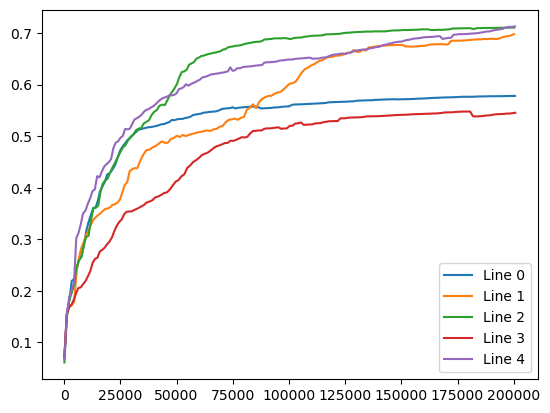

In [138]:
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i-1}')

# Show legend to differentiate between lines
plt.legend()

# Show the plot
plt.show()


In [ ]:
os.getcwd()

# IRRIGATION CASE

In [202]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [203]:
from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7, \
        Irrigation8, Irrigation9 = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ]


In [204]:
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [205]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [206]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 200000 #
seeds = 5
run_comment = 'hv_feb'
run_label = f"IR_{nfe}nfe_{seeds}seed" #{run_comment}_

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_200000nfe_5seed'

Change the load archives method of the ArchiveLogger class

In [208]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
    #archives, normalized_archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
    #print(archives)
    all_archives.append(archives)

# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
    print(len(result))
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.65] * len(model.outcomes), problem)  # [0.05]
len(reference_set)

In [218]:
# Get the worst values (Nadir point)

# Load the merged results
column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']
df_irr = pd.read_csv(f"merged_results.csv", usecols = column_names)#, index_col=0) #, usecols = column_names)

worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_irr.Hydropower.min()
best_irr = df_irr.Irrigation.min()
best_env = df_irr.Environment.min()
best_irr2 = df_irr.Irrigation2.min()
best_irr3 = df_irr.Irrigation3.min()
best_irr4 = df_irr.Irrigation4.min()
best_irr5 = df_irr.Irrigation5.min()
best_irr6 = df_irr.Irrigation6.min()
best_irr7 = df_irr.Irrigation7.min()
best_irr8 = df_irr.Irrigation8.min()
best_irr9 = df_irr.Irrigation9.min()

best_list = []
best_list.append(best_hyd)
best_list.append(best_env)
best_list.append(best_irr)

In [215]:
print(worst_list)

[25.74081684919041, 4310959.95115732, 5.015280413166653, 0.7919088176780325, 0.8823536420980886, 0.7680897062118321, 0.5210214631927633, 0.7682683518976562, 0.5, 0.9166666666666666, 0.7764201966845683]


In [219]:
import tarfile
import os
import pandas as pd

column_names = ['Hydropower', 'Environment', 'Irrigation','Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', 'Irrigation7', 'Irrigation8', 'Irrigation9']

def alternative_load_archives(filename):
    archives = {}
    normalized_archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                normalized_df=(df-df.min())/(df.max()-df.min())
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not normalized_df.empty:
                    normalized_archives[int(key)] = normalized_df
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, normalized_archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [220]:
# Load the archives
#all_archives = []
#all_hvs = {}
all_norm_hvs = []
norm_hvs_dict = {}

norm_hvs_dict_0 = {}
norm_hvs_dict_1 = {}
norm_hvs_dict_2 = {}
norm_hvs_dict_3 = {}
norm_hvs_dict_4 = {}
norm_hvs_dict_5 = {}

hvs_dict_0 = {}
hvs_dict_1 = {}
hvs_dict_2 = {}
hvs_dict_3 = {}
hvs_dict_4 = {}
hvs_dict_5 = {}

for i in range(seeds):
    norm_hvs_this_seed = []
    archives, normalized_archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

    norm_sorted_archives = dict(sorted(norm_archives.items()))
    for key, value in norm_sorted_archives.items():

        o = value.values

        norm_objs = np.ascontiguousarray(o)
        if key < 100:
            #print('objs:', norm_objs)
            
        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)
        if key < 110:
            #print('norm_hv::',norm_hv)

        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv

        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv

        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv

        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv

        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv

        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv

    
    print('all hvs for seed', i, ':', norm_hvs_this_seed)
norm_hvs_dict_0


hv:: 337615.73062103905
norm_hv:: 0.015711465635589873
all hvs for seed 0 : [0.015711465635589873, 0.001185506384879026, 0.004973244877962248, 0.005025820952347284, 0.005059331092804661, 0.005270040230799812, 0.008301596042182838, 0.008405767345012024, 0.00919214597313109, 0.010179590520295346, 0.011825838508482093, 0.014127110611534821, 0.014416828870250266, 0.014586146784619574, 0.014850816271473244, 0.02562584764195002, 0.029161377849432474, 0.028367549330914517, 0.03840928236788931, 0.03852394600947483, 0.040928638940873424, 0.040361334506959765, 0.04192851001575661, 0.06295781615812839, 0.06420166912620434, 0.06451432688337107, 0.06961722464244895, 0.07312555959178446, 0.08186431313704899, 0.08380293721686986, 0.10730160370393182, 0.10804518054825299, 0.11006586210166285, 0.1216541956204954, 0.14434790457587518, 0.14498774952657087, 0.14508939487982156, 0.14794260510831797, 0.14379443355107469, 0.14393542052258662, 0.14626745578270944, 0.14701924367976288, 0.15050743472622133, 0.1

{100: 0.015711465635589873,
 1186: 0.001185506384879026,
 2266: 0.004973244877962248,
 3351: 0.005025820952347284,
 4432: 0.005059331092804661,
 5513: 0.005270040230799812,
 6601: 0.008301596042182838,
 7694: 0.008405767345012024,
 8780: 0.00919214597313109,
 9876: 0.010179590520295346,
 10910: 0.011825838508482093,
 11988: 0.014127110611534821,
 13065: 0.014416828870250266,
 14140: 0.014586146784619574,
 15223: 0.014850816271473244,
 16305: 0.02562584764195002,
 17383: 0.029161377849432474,
 18460: 0.028367549330914517,
 19540: 0.03840928236788931,
 20616: 0.03852394600947483,
 21694: 0.040928638940873424,
 22771: 0.040361334506959765,
 23851: 0.04192851001575661,
 24931: 0.06295781615812839,
 26013: 0.06420166912620434,
 27094: 0.06451432688337107,
 28343: 0.06961722464244895,
 29734: 0.07312555959178446,
 31126: 0.08186431313704899,
 32520: 0.08380293721686986,
 33908: 0.10730160370393182,
 35299: 0.10804518054825299,
 36692: 0.11006586210166285,
 38086: 0.1216541956204954,
 39477: 

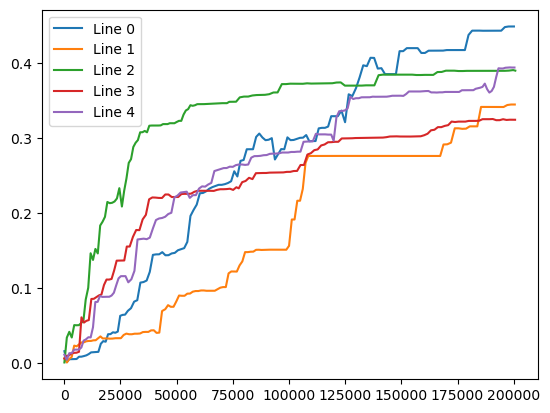

In [182]:
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i-1}')

plt.title('Hypervolume irrigation case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = 'irr_hv.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()

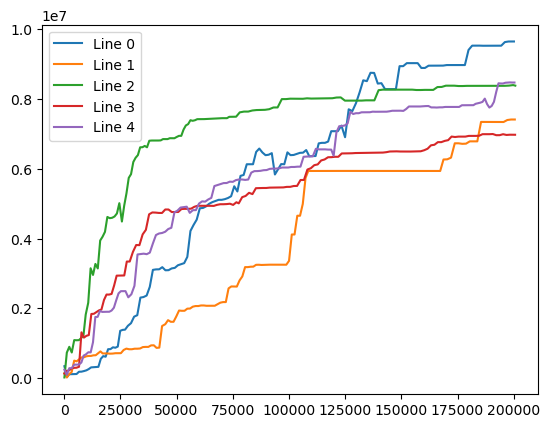

In [221]:
hvs_dicts = [hvs_dict_0, hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    lists = hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i-1}')

# Show legend to differentiate between lines
plt.legend()

# Show the plot
plt.show()

# HYDROPOWER CASE

In [250]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [251]:
from model_zambezi_OPT_hyd import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]


In [252]:
#Problem definition
problem = to_problem(model, searchover="levers")

Run definition

In [253]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [254]:

nfe = 200000 #
seeds = 5
run_comment = 'e4647'
run_label = f"HYD_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\HYD_e4647_200000nfe_5seed'

Merge convergences 

In [255]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)
    
#print(all_archives)

# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.05] * len(model.outcomes), problem)  # [0.05]

In [265]:
# Get the worst values (Nadir point)

# Load the merged results
#column_names = ['Hydropower', 'Environment', 'Irrigation']
column_names = ['Hydropower', 'Environment', 'Irrigation', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']
df_hyd = pd.read_csv(f"merged_results.csv", usecols = column_names)#, index_col=0) #, usecols = column_names)

worst_hyd = df_hyd.Hydropower.max()
worst_irr = df_hyd.Irrigation.max()
worst_env = df_hyd.Environment.max()
worst_hydITT = df_hyd.HydropowerITT.max()
worst_hydKGU = df_hyd.HydropowerKGU.max()
worst_hydKA = df_hyd.HydropowerKA.max()
worst_hydCB = df_hyd.HydropowerCB.max()
worst_hydKGL = df_hyd.HydropowerKGL.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_hyd.Hydropower.min()
best_irr = df_hyd.Irrigation.min()
best_env = df_hyd.Environment.min()
best_hydITT = df_hyd.HydropowerITT.min()
best_hydKGU = df_hyd.HydropowerKGU.min()
best_hydKA = df_hyd.HydropowerKA.min()
best_hydCB = df_hyd.HydropowerCB.min()
best_hydKGL = df_hyd.HydropowerKGL.min()

best_list = []
best_list.append(best_hyd)
best_list.append(best_env)
best_list.append(best_irr)

In [266]:
print(worst_list)

[24.39555462582556, 5647555.60499013, 5.596474807484928]


In [269]:
import tarfile
import os
import pandas as pd

#column_names = ['Hydropower', 'Environment', 'Irrigation']
column_names = ['Hydropower', 'Environment', 'Irrigation', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']

def alternative_load_archives(filename):
    archives = {}
    normalized_archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                normalized_df=(df-df.min())/(df.max()-df.min())
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)

                if not df.empty:
                    archives[int(key)] = df
                if not normalized_df.empty:
                    normalized_archives[int(key)] = normalized_df
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, normalized_archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [270]:
# Load the archives
#all_archives = []
#all_hvs = {}
all_norm_hvs = []
norm_hvs_dict = {}
norm_hvs_dict_0 = {}
norm_hvs_dict_1 = {}
norm_hvs_dict_2 = {}
norm_hvs_dict_3 = {}
norm_hvs_dict_4 = {}
norm_hvs_dict_5 = {}

hvs_dict_0 = {}
hvs_dict_1 = {}
hvs_dict_2 = {}
hvs_dict_3 = {}
hvs_dict_4 = {}
hvs_dict_5 = {}

for i in range(seeds):
    norm_hvs_this_seed = []
    archives, normalized_archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

    norm_sorted_archives = dict(sorted(norm_archives.items()))
    for key, value in norm_sorted_archives.items():

        o = value.values

        norm_objs = np.ascontiguousarray(o)

        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)

        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv

        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv

        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv

        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv

        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv

        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv

    print('all hvs for seed', i, ':', norm_hvs_this_seed)
norm_hvs_dict_0


all hvs for seed 0 : [0.05859680804296931, 0.22339904424987242, 0.2431898686676698, 0.2516984972737058, 0.25895542127925864, 0.269439114468086, 0.28318679665388014, 0.29975391223029174, 0.31626680864683215, 0.32293722434984595, 0.3306147713146773, 0.3342472531571058, 0.3492307983403071, 0.3513948734820536, 0.3571366732193635, 0.3607600559568287, 0.3657801253417064, 0.36716172435179206, 0.3706645220400718, 0.37339356823218056, 0.37479804903033526, 0.3769626454220653, 0.37821113615703905, 0.3788823234735423, 0.3791165236678129, 0.3816504577972845, 0.3822224545469284, 0.3821166193583696, 0.38367851778429996, 0.3944922899087597, 0.3955760911873892, 0.3962584518694595, 0.40107768303681307, 0.4015170427306527, 0.402956001684666, 0.40336737519941085, 0.4044105110417618, 0.4076885640403782, 0.4088048132587707, 0.4114660174031965, 0.4115961304473726, 0.4128288633585284, 0.41325106603753853, 0.4136218264080927, 0.4155961658314076, 0.4164565428919157, 0.41941968940162017, 0.42123504399855094, 0.4

{100: 0.05859680804296931,
 1187: 0.22339904424987242,
 2281: 0.2431898686676698,
 3378: 0.2516984972737058,
 4478: 0.25895542127925864,
 5572: 0.269439114468086,
 6671: 0.28318679665388014,
 7770: 0.29975391223029174,
 8775: 0.31626680864683215,
 9776: 0.32293722434984595,
 10912: 0.3306147713146773,
 11929: 0.3342472531571058,
 12948: 0.3492307983403071,
 13971: 0.3513948734820536,
 14993: 0.3571366732193635,
 16014: 0.3607600559568287,
 17032: 0.3657801253417064,
 18054: 0.36716172435179206,
 19076: 0.3706645220400718,
 20096: 0.37339356823218056,
 21118: 0.37479804903033526,
 22137: 0.3769626454220653,
 23159: 0.37821113615703905,
 24180: 0.3788823234735423,
 25201: 0.3791165236678129,
 26222: 0.3816504577972845,
 27243: 0.3822224545469284,
 28265: 0.3821166193583696,
 29286: 0.38367851778429996,
 30306: 0.3944922899087597,
 31324: 0.3955760911873892,
 32344: 0.3962584518694595,
 33366: 0.40107768303681307,
 34387: 0.4015170427306527,
 35408: 0.402956001684666,
 36428: 0.4033673751

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\HYD_e4647_200000nfe_5seed


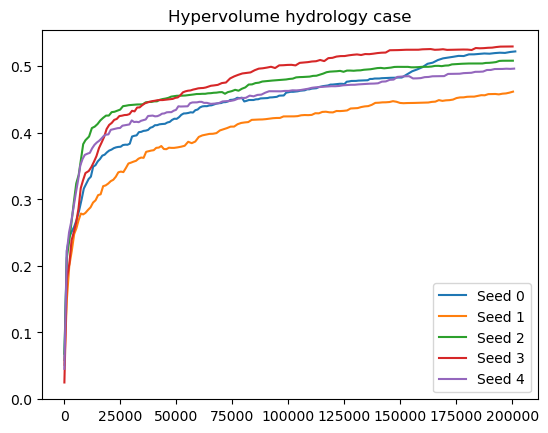

In [272]:
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i-1}')

plt.title('Hypervolume hydrology case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = 'hyd_hv.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()


# FULL DISAGGREGATION CASE

In [20]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [21]:
from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7,\
        Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = \
        tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]


In [22]:
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [23]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [24]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 10 #
seeds = 1
run_comment = 'test'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_hv_feb_10000nfe_1seed'

Change the load archives method of the ArchiveLogger class

In [25]:
import tarfile 
def alternative_load_archives(filename): #cls,
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                archives[int(key)] = pd.read_csv(fh.extractfile(entry), index_col=0)
    return archives

ArchiveLogger.load_archives = alternative_load_archives

Merge convergences 

In [26]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

In [27]:
# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)

In [28]:
# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

In [29]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.05] * len(model.outcomes), problem)  # [0.05]
#print('reference_set', reference_set)
#print('reference_set type is', type(reference_set))

In [30]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

In [ ]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)

    metrics_by_seed.append(metrics)

In [ ]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")
    
sns.despine(fig)

plt.show()